# Project Description
This project is about exploring speech data from South Park with NLP. We'll look at how to process NLP data, build and interpret NLP pipelines, calculate and intrepret different word association metrics, and assess different pipeline configurations for text classification. 

## Processing Speech Data
Linguistic data is a particularly complex and challenging type of data to mine and analyze. Like other types of data, text documents require processing of raw data into clean, structured features in order to be modeled. However, processing of linguistic data is uniquely tricky for several reasons--two of which being that text is not numeric and that interpreting speech is difficult and subjective. 

This is why data processing and feature extraction is an especially involved process for NLP. We'll break down NLP processing with first principles to provide a more interpretable understanding. First, let's load our csv-formatted South Park speech data.

In [1]:
import pandas as pd
df = pd.read_csv('all_seasons.csv',header = 0,skiprows=0)
print(df)

      Season Episode Character  \
0         10       1      Stan   
1         10       1      Kyle   
2         10       1      Stan   
3         10       1      Chef   
4         10       1      Stan   
...      ...     ...       ...   
70891      9      14      Stan   
70892      9      14     Randy   
70893      9      14      Stan   
70894      9      14     Randy   
70895      9      14      Stan   

                                                    Line  
0             You guys, you guys! Chef is going away. \n  
1                            Going away? For how long?\n  
2                                             Forever.\n  
3                                      I'm sorry boys.\n  
4      Chef said he's been bored, so he joining a gro...  
...                                                  ...  
70891                       I think you're pushing it.\n  
70892                                How about twenty?\n  
70893                           That's not disciprine.\n  
7

We can see that our raw data has 70,896 South Park quotes. Each quote has three accompanying characteristics: the season in which it appeared, the episode in which it appeared, and the character who spoke it. In terms of NLP terminology, each quote is considered a document, and each word in a document is considered a term.

Processing raw text data with NLP typically consists of **tokenization**, followed by **word reduction**, and then concluded with **vectorization**. These operations are performed sequentially, so they represent a **pipeline**. Tokenization is usually the most straightfoward part of such a pipeline. It deconstructs speech into individual words of interest. **Stop words** are the words which will be filtered out during the tokenization process and thus won't be considered in the model. Some common stop words are conjunctions like "or," and "the," which provide little to no meaningful information--especially when isolated from their surrounding context. Here's an example to illustrate tokenization with nltk and how it varies with different stop words. 

In [2]:
import nltk

document = 'The lazy fox jumped over the log.'
print("Input document: " + str(document))
print()

stop_words = set(['the'])
tokens = nltk.word_tokenize(document.lower())
valid_tokens = [token for token in tokens if token not in stop_words]
print("Tokenization with stop words = {'the'}: " + str(valid_tokens))

stop_words = set(['the','over'])
tokens = nltk.word_tokenize(document.lower())
valid_tokens = [token for token in tokens if token not in stop_words]
print("Tokenization with stop words = {'the','over'}: " + str(valid_tokens))

Input document: The lazy fox jumped over the log.

Tokenization with stop words = {'the'}: ['lazy', 'fox', 'jumped', 'over', 'log', '.']
Tokenization with stop words = {'the','over'}: ['lazy', 'fox', 'jumped', 'log', '.']


You might notice that one of the tokens is punctuation. Whether to consider punctuation or filter it out is another one of many choices you have for NLP processing. I prefer to include punctuation bcause it can indicate emotional context, as well as writing style if the document was written by the speaker directly. However, if filtering out punctuation is of interest to you, here's a simple method for doing so.

In [3]:
import string

def remove_punctuation(word):
    for char in word:
        if char in string.punctuation:
            word = word.replace(char,'')
    
    return word

print("Tokens before punctuation filter: " + str(valid_tokens))
unpunctuated_tokens = [remove_punctuation(token) for token in valid_tokens if remove_punctuation(token)]
print("Tokens after punctuation filter: " + str(unpunctuated_tokens))

Tokens before punctuation filter: ['lazy', 'fox', 'jumped', 'log', '.']
Tokens after punctuation filter: ['lazy', 'fox', 'jumped', 'log']


Word reduction is the simplification of words to their root words. *Why simplify words in such a way?* One source of motivation is to represent different variations of the same word equivalently. Through doing so, we minimize both the amount of considered words and the complexity of our model. Stemming and lemmatization are two different approaches for word reduction. 

Lemmatization considers the way in which a word is used (its *morphology*) when reducing it, while stemming is restricted to word transformation through simple operations like removing suffixes and prefixes. Lemmatization is qualitatively superior to stemming because it represents words according to their surrounding contexts, but it typically takes more time. 

Here are some simple stemmer and lemmatizer classes. They both tokenize a document into word tokens, which are then either stemmed or lemmatized into core words. Once the word reduction has completed, its resulting data will be ready for building features.

In [4]:
from nltk import WordNetLemmatizer as wnl
from nltk.stem import PorterStemmer

class Stemmer(object):
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self, doc):
        tokens = nltk.word_tokenize(doc.lower())
        stems = [self.stemmer.stem(token) for token in tokens]
        
        return stems

class Lemmatizer(object):
    def __init__(self):
        self.wnl = wnl()
    def __call__(self, doc):
        tokens = nltk.word_tokenize(doc.lower())
        lemmas = [self.wnl.lemmatize(token) for token in tokens]
        
        return lemmas
                    

Now we can finish the processing phase with vectorization: the mapping of pre-processed tokens into a numerical representation. Basically, we need to express our tokens in terms of informative numerical features so that we can analyze and model them. The two most common vectorization methods are **count vectorization** and **tfidf**. We'll discuss tfidf shortly, but for now, we'll stick to count vectorization. Count vectorization simply measures the amount of times each token appears in each document. These measurements can be used to build an (m x n) **term document matrix** with some key properties: 
* It has $m$ rows, where $m$ = # of documents (or quotes).
* It has $n$ columns, where $n$ = # of tokens.
* Its $(i,j)$th element is the frequency with which $token_{i}$ appears in $document_{j}$.

Using nltk and sklearn, we'll process our speech data with a count vectorizer to begin some exploration and analysis of the data. Sklearn vectorizers are capable of all pre-processing tasks: tokenization, stemming and/or lemmatization, and vectorization. Finding least and most popular tokens is a useful way to start exploring linguistic data and to validate that your processing system is working well. Note that for a term document matrix, a column's sum represents a word's total frequency across all documents. So we can find a word's frequency by calculating its column sum.

In [5]:
import numpy as np
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import text

# Download some random nltk data we need.
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

# Create a count vectorizer for tokenizing, lemmatizing and vectorizing our raw quotes. #min_df = minimum token count for the token to be included. 
stop_words = stopwords.words('english')
count_vectorizer = CountVectorizer(min_df=2,tokenizer=Lemmatizer(),stop_words=stop_words)
quotes = df['Line']
document_term_matrix = count_vectorizer.fit_transform(quotes)

# Get the top <num_words> most popular words from a document term matrix and its vectorizer.
def get_top_words(num_words,document_term_matrix,count_vectorizer):
    word_totals = np.sum(document_term_matrix,axis=0)
    descending_cols = np.argsort(-word_totals,axis=1)
    descending_cols = np.squeeze(np.asarray(descending_cols))
    max_cols = list(descending_cols)[0:num_words]
    popular_counts = [word_totals[0,col] for col in max_cols]
    
    column_words = count_vectorizer.get_feature_names()
    popular_words = [column_words[col] for col in max_cols]
    word_counts = dict(zip(popular_words,popular_counts))
    
    return word_counts

num_words = 15
top_word_counts = get_top_words(num_words,document_term_matrix,count_vectorizer)
i = 1
print("Most popular words.")
print()
for word,count in top_word_counts.items():
    print(str(i) + '. ' + word + ': ' + str(count))
    i += 1

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/camjohn/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/camjohn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camjohn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Most popular words.

1. ,: 62722
2. .: 62365
3. !: 43523
4. ?: 24138
5. 's: 16402
6. n't: 10581
7. ...: 6623
8. 're: 5674
9. oh: 5613
10. 'm: 5017
11. get: 4155
12. yeah: 3672
13. know: 3593
14. na: 3534
15. well: 3530


There's an inconsistency problem in our processing pipeline. Inconsistency in this context means that pre-processing stop words (tokenization,lemmatization,stemming...) produces some valid words not contained in stop words. Additionally, the most popular words above fail the intuition test. More specifically, some of the popular tokens, like "n't", are word fragments that have no independent meaning.

Rather than experiment with different stop words and lemmatization/stemming methods (of which there are many), we'll try a simpler trick. Unless the problem demands for specific, custom pre-processing, returning to default NLP configurations in Python is likely an effective solution. Also, sklearn's countvectorizer is fairly robust and can be a good default option to fall back on.

In [6]:
count_vectorizer = CountVectorizer(min_df=2,stop_words=stop_words)
document_term_matrix = count_vectorizer.fit_transform(quotes)
top_word_counts = get_top_words(num_words,document_term_matrix,count_vectorizer)
i = 1
print("Most popular words.")
for word,count in top_word_counts.items():
    print(str(i) + '. ' + word + ': ' + str(count))
    i += 1

Most popular words.
1. oh: 5774
2. get: 4009
3. yeah: 3705
4. well: 3583
5. know: 3474
6. right: 3462
7. like: 3243
8. go: 3206
9. come: 2614
10. gonna: 2567
11. let: 2445
12. see: 2419
13. uh: 2351
14. us: 2254
15. think: 2224


Not only is the pre-processing now consistent, but it looks much better intuitively. Most popular tokens are now valid words that make sense given our knowledge of South Park. We'll now implement a similar algorithm for finding rarest words.

In [7]:
# Same idea as above, except that we're now finding words whose respective column sums are minimal. 
# It follows that these words correspond to the rarest words.
def get_rarest_words(num_words,document_term_matrix,count_vectorizer):
    word_totals = np.sum(document_term_matrix,axis=0)
    ascending_cols = np.argsort(word_totals,axis=1)
    ascending_cols = np.squeeze(np.asarray(ascending_cols))
    min_cols = list(ascending_cols)[0:num_words]
    
    column_words = count_vectorizer.get_feature_names()
    rarest_words = [column_words[col] for col in min_cols]
    rarest_counts = [word_totals[0,col] for col in min_cols]
    word_counts = dict(zip(rarest_words,rarest_counts))
    
    return word_counts

rarest_word_counts = get_rarest_words(num_words,document_term_matrix,count_vectorizer)
i = 1
print("Least popular words.")
print()
for word,count in rarest_word_counts.items():
    print(str(i) + '. ' + word + ': ' + str(count))
    i += 1

Least popular words.

1. 00: 2
2. irritable: 2
3. irrational: 2
4. irons: 2
5. irish: 2
6. irimasu: 2
7. ir: 2
8. involving: 2
9. irwin: 2
10. involvement: 2
11. invent: 2
12. invaded: 2
13. intricate: 2
14. intoxicated: 2
15. intervene: 2


If you're curious about how to thoroughly test and validate these rarest words, that's a great curiosity to have. Unfortunately, this is a feature engineering result for which proving some notion of accuracy is difficult. Instead, we can use our intuition about English and South Park, as well as the most popular word counts, to suggest that the rarest words and their respective counts seem reasonable. Intuition is a helpful and sometimes neccessary tool for exploratory analysis.

Note that word frequency is a poor metric for measuring word importance and word associations. You can learn about some of these flaws in more depth below.
* Some of the most universal english words are structural parts of speech (ie, conjunctions and prepositions) that have little to no individual meaning or value. Because their purpose is to provide relational context between words in the same sentence, a lot of the original info these words had (which wasn't much to begin with) is lost when they're isolated. Linguistic meaning is far from linear. Ie, words, sentences, paragraphs,... collectively represent something very different from their individual components. Context usually matters quite a bit. 


* Consider word frequency in the context of a random variable's distribution. The more likely a random variable is to have certain outcomes, the less informative those outcomes are when they occur. Why? Because they were anticipated more strongly than the less likely outcomes. For ex, if you know that Jack yells "Wolf," with probability 1, how much information do you gain when that happens? Zero. Conversely, if Jack never says "Wolf" but then suddenly shouts it, that is a very surprising event. Surprise, in this context, embodies information. 

## Tfidf Vectorization
Now we'll restructure our processed features with a **tfidf** vectorizer. Tfidf is a NLP metric which scales a term's frequency (or "tf") by an inverse document frequency factor (or "idf"). Idf is defined as the inverse ratio of # of documents containing the term to total # of documents. So idf grows as a term's number of documents declines, thereby increasing that term's tfidf with its associated documents (for unassociated documents, tf=0 so the tf*idf product will be zero). 

Conversely, idf decays when a term's amount of associated documents increases. Intuition behind this idea is that there is a stronger, more informative association between a word and a document if the word is not likely to be found in other documents. As previously discussed, words that frequently occur in different documents are inherently less informative about the documents in which they appear.   

In [8]:
vectorizer = TfidfVectorizer(min_df=2, analyzer='word',stop_words='english',norm='l2',sublinear_tf=True,binary=False,smooth_idf=True,max_features=1000)
quotes = df['Line']
lemmatized_quotes = vectorizer.fit_transform(quotes)
tf = TfidfTransformer()
tf_mat = tf.fit_transform(lemmatized_quotes)
print(tf_mat)

  (0, 372)	0.55531296607134
  (0, 149)	0.5669614622726928
  (0, 350)	0.35040515085250046
  (0, 47)	0.49739163670763203
  (1, 350)	0.42886676673384494
  (1, 47)	0.6087660027721742
  (1, 516)	0.6674408215415409
  (2, 307)	1.0
  (3, 796)	0.7205934104145973
  (3, 93)	0.6933578707039098
  (4, 149)	0.3302075304863642
  (4, 724)	0.27407759100374846
  (4, 367)	0.5102521540743851
  (4, 119)	0.3668787769671991
  (4, 837)	0.4313877113212251
  (4, 164)	0.4845532021504104
  (5, 986)	1.0
  (6, 149)	0.35844658459705236
  (6, 475)	0.3548475725379728
  (6, 683)	0.5619341875941813
  (6, 870)	0.1944036001458559
  (6, 980)	0.3188581962959062
  (6, 353)	0.18427948734075425
  (6, 31)	0.5063664448975309
  (7, 504)	1.0
  :	:
  (70884, 791)	0.6633014365989471
  (70884, 866)	0.7483523262513272
  (70885, 697)	0.27739738453292456
  (70885, 786)	0.7369264640963332
  (70885, 855)	0.616433352089882
  (70886, 859)	0.243493301936715
  (70886, 609)	0.11472388316311563
  (70886, 506)	0.1527033361166822
  (70886, 501)	0.

As part of exploratory analysis, let's build a character frequency distribution to see how well each character is represented in our data. For each character, we'll calculate its quote quantity. 

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Create a feature encoder. Feature encoders are used to map feature indices to their respective features and vice-versa.
# In this application, we're now exploring a different feature: the quote's speaking character. The label encoder
# will encode the character column in 'df' with integer indices--allowing for character information to be represented in our analysis.

encoder = LabelEncoder()
characters = df["Character"]
encoder.fit(characters)
characters_encoded = encoder.transform(characters)
characters = encoder.classes_
encodings = encoder.transform(characters)
decoder = dict(zip(encodings,characters))

# Dictionaries below are intended for accessing a character's list of rows (=character's quotes), and its frequency = # of quotes.
character_to_rows = {char:[] for char in characters}
character_to_total = {char:0 for char in characters}
for row,character_encoded in enumerate(characters_encoded):
    character = decoder[character_encoded]
    character_to_rows[character].append(row)
    character_to_total[character] += 1

# Determine most popular characters through sorting character frequencies. 
popular_characters = sorted(character_to_total,key=character_to_total.get,reverse=True)
popular_totals = [character_to_total[character] for character in popular_characters]
characters_data = {"Character":popular_characters}
df_characters = pd.DataFrame(characters_data)
df_characters.insert(1,"# of Quotes",popular_totals)

print("Most Popular Characters")
print()
print(df_characters)

Most Popular Characters

             Character  # of Quotes
0              Cartman         9774
1                 Stan         7680
2                 Kyle         7099
3              Butters         2602
4                Randy         2467
...                ...          ...
3945  You And Me, Girl            1
3946      Young Worker            1
3947  Younger Daughter            1
3948          Zipliner            1
3949  Zombie Mortician            1

[3950 rows x 2 columns]


Now we'll produce some visuals for both character frequency and average character polarity. Polarity captures the emotional positivity of a document through averaging the polarity of its individual words. Its range of values is [-1,1], where -1 and 1 correspond to negative and positive, respectively. 

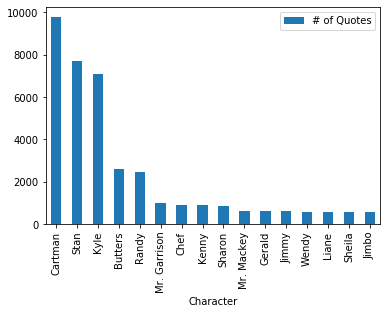

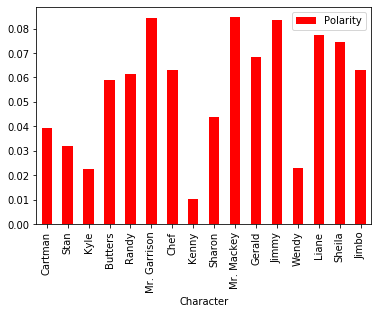

In [10]:
from textblob import TextBlob

def character_polarity(character,character_to_rows,quotes):
    character_rows = character_to_rows[character]
    average_polarity = 0.0
    for row in character_rows:
        average_polarity += TextBlob(quotes[row]).sentiment.polarity
        #print(quotes[row])
        #print(TextBlob(quotes[row]).sentiment.polarity)
    
    average_polarity = average_polarity / float(len(character_rows))
    
    return average_polarity
        
top_characters = df_characters.loc[df_characters['# of Quotes'] >= 500]
top_characters_polarity = [character_polarity(character,character_to_rows,quotes) for character in top_characters['Character']]
top_characters.insert(2,'Polarity',top_characters_polarity)
top_characters.plot.bar(x='Character',y='# of Quotes')
top_characters.plot.bar(x='Character',y='Polarity',color='red')

The character frequency bar plot validates data quality in the sense that the most represented characters are those which are the most represented in the show. Character polarity is a bit more interesting--particularly with regards to some noticeable outliers. Cartman is one of the most notoriously evil characters in animated television, yet his average polarity is positive and somewhat normal relative to the other main characters. More generally, average polarity is positive for every character, despite the fact that these characters range from moderately cynical to completely egregious (except for Butters!). This is mild evidence of a slight positive bias in TextBlob's polarity measure. 

## Word Character Relationships 

**Logistic modeling** is a standard supervised learning approach for classification and regression. It's especially valuable in that it has a very clear, probabilistic interpretation. For example, log regression can be used in learning chess to predict who will win given the current board. After training on thousands of games, the logistic output from a board will represent either the probability of white winning (regression), or the player most likely to win (classification). Note that this probabilistic interpretation quality is very unique. Other models, such as SVM and decision trees, cannot be interpreted in probabilistic frameworks, and rely on linear algebra for relevance.

This concept extends to multinomial problems, where the predicted variable has more than 2 possible outcomes. Since we're concerned with predicting a quote's character from more than two possible characters, a multinomial model is appropriate. Let's train a multinomial logistic model using sklearn to predict speaking character from South Park quotes. Then, we'll use these logistic coefficients to determine characteristic words for some popular characters. A **characteristic word** for a character is one that is strongly associated to that character--it indicates that character may have spoken it. We could use sklearn's feature importance directly, but instead we'll develop a quick algorithm to illustrate the underlying linear algebra and logic.

In [11]:
from sklearn.linear_model import LogisticRegression

# weights_matrix has the coefficients derived from the trained logistic model. Its (i,j)th coefficient 
# represents the weight word_j has on character_i's likelihood. For example, the word 'mr. slave' likely has a large coefficient for Mr. Garrison.
log_classifier = LogisticRegression(solver='sag',multi_class='multinomial').fit(tf_mat,characters_encoded)
weights_matrix = log_classifier.coef_
character_words = []
key_characters = ['Cartman', 'Kyle', 'Stan', 'Randy', 'Kenny', 'Chef', 'Wendy', 'Butters', 'Sharon', 'Craig', 'Towelie', 'Mr. Garrison', 'Mr. Slave', 'Token', 'Jimbo', 'Ned', 'Timmy', 'Jimmy', 'Mr. Mackey', 'Satan', 'Terrance', 'Phillip', 'Big Gay Al', 'Tweek', 'Grandpa', 'Ike']
feature_words = vectorizer.get_feature_names()
for char in key_characters:
    row = encoder.transform([char])
    word_weights = weights_matrix[row,:]
    sorted_features = np.argsort(-word_weights,axis=1)
    sorted_features = np.squeeze(np.asarray(sorted_features))
    sorted_words = [feature_words[feat] for feat in sorted_features]
    words = sorted_words[0:10]
    character_words.append(words)
    
dic = {"Character":key_characters}
df_main = pd.DataFrame(dic)
df_main.insert(1,"Characteristic Words via Logistic Feature Importance",character_words)
print(df_main)

       Character Characteristic Words via Logistic Feature Importance
0        Cartman  [dude, kyle, guys, butters, kenny, kitty, mom,...  
1           Kyle  [dude, cartman, fatass, ike, hankey, stan, dre...  
2           Stan  [dude, cartman, kyle, dad, kenny, grandpa, fat...  
3          Randy  [sharon, stanley, stan, shelly, gerald, cruise...  
4          Kenny  [dude, woohoo, guys, fuck, fucking, fuckin, aw...  
5           Chef  [children, flag, women, aliens, pip, doctor, b...  
6          Wendy  [stan, bebe, guys, list, cartman, egg, girls, ...  
7        Butters  [fellas, awesom, dad, jeez, eric, chaos, groun...  
8         Sharon  [stanley, randy, stan, shelly, son, sweetie, s...  
9          Craig  [guys, craig, dude, sooo, butters, xbox, red, ...  
10       Towelie  [high, towel, goin, bring, towelie, asshole, f...  
11  Mr. Garrison  [hat, children, stanley, eric, mr, teacher, cl...  
12     Mr. Slave  [christ, jesus, garrison, whore, sweetie, mr, ...  
13         Token  [r

In [12]:
# Lift is a popular association rule used in data mining. Closely connected to Bayesian statistics. 
# Basic concept is to measure variable association with simple Bayesian probabilities. How likely is X to occur given Y? How likely was Y to occur to begin with?
num_rows,num_cols = document_term_matrix.shape
cols,rows = np.arange(num_cols),np.arange(num_rows)
column_words = count_vectorizer.get_feature_names()
word_columns = {column_words[col]:col for col in cols}
words = word_columns.keys()
character_words = []

# Normalize tfidf scores across both dimensions to form a character based tfidf probability density function.
total = np.sum(np.sum(document_term_matrix[:,:],axis=0),axis=1)

# For each key character, we'll measure how characteristic a word is with that word's lift on the character.
# Lift(X -> Y) = prob(X and Y)/prob(X)*prob(Y) = prob(X|Y)/prob(X) 
for character in key_characters:
    character_rows = character_to_rows[character]
    character_total = np.sum(document_term_matrix[character_rows,:])
    prior = character_total/total
    lifts = {}
    for word in words:
        col = word_columns[word]
        character_word_total = np.sum(document_term_matrix[character_rows,col])
        posterior = np.float(character_word_total)/np.float(character_total)
        lift = posterior/prior
        lifts[word] = lift

    sorted_words = sorted(lifts,key=lifts.get,reverse=True)
    top_words = sorted_words[0:10]
    character_words.append(top_words)

df_lift = pd.DataFrame({"Character":key_characters})
df_lift.insert(1,"Characteristic Words via Lift",character_words)
print(df_lift)     

       Character                      Characteristic Words via Lift
0        Cartman  [oh, kyle, guys, get, right, know, go, gonna, ...
1           Kyle  [dude, cartman, yeah, get, know, oh, go, gonna...
2           Stan  [dude, yeah, oh, cartman, get, go, know, gonna...
3          Randy  [oh, stan, yeah, get, know, well, right, sharo...
4          Kenny  [yeah, oh, hey, fuck, guys, dude, uh, woohoo, ...
5           Chef  [children, oh, get, well, know, come, hello, g...
6          Wendy  [stan, oh, know, like, guys, bebe, hey, really...
7        Butters  [oh, uh, well, hey, yeah, know, get, like, go,...
8         Sharon  [randy, oh, stanley, know, right, go, get, wel...
9          Craig  [guys, yeah, hey, get, us, could, gonna, oh, g...
10       Towelie  [get, high, towel, oh, yeah, bring, hey, goin,...
11  Mr. Garrison  [mr, oh, children, well, hat, okay, get, know,...
12     Mr. Slave  [jesus, christ, oh, garrison, mr, whore, aah, ...
13         Token  [yeah, oh, know, like, gonna, 

Now we'll find characteristic words using the lift assocation rule, with class likelihoods and word priors taken from a multinomial **Naive Bayes** model. Naive Bayes is one of the tried and true classification approaches. It assumes that all features are conditionally independent: a feature's information about a class is independent of all other features. Hence, the naivety. In practice, however, this assumption usually doesn't result in much approximation error. Strengths of Naive Bayes include training speed, robustness, simplicity and interpretability. 

In [13]:
classifier = MultinomialNB().fit(tf_mat,characters_encoded)
posteriors = classifier.feature_log_prob_
posteriors = np.exp(posteriors)
word_priors = np.sum(posteriors,axis=0)
char_probs = np.exp(classifier.class_log_prior_)
feature_characters = encoder.classes_
lift_words = []
for character in key_characters:
    index = encoder.transform([character])
    char_posteriors = posteriors[index]
    lifts = np.divide(char_posteriors,word_priors)
    top_cols = np.argsort(-lifts,axis=1)
    top_cols = np.squeeze(np.asarray(top_cols))
    top_words = [feature_words[col] for col in top_cols]
    lift_words.append(top_words)
  
df_lift = pd.DataFrame({"Character":key_characters})
df_lift.insert(1,"Characteristic Words via Naive Bayes Lift",lift_words)
print(df_lift)   

       Character          Characteristic Words via Naive Bayes Lift
0        Cartman  [kyle, guys, butters, oh, yeah, right, dude, m...
1           Kyle  [cartman, dude, yeah, don, stan, know, oh, ike...
2           Stan  [dude, yeah, cartman, dad, don, oh, kyle, know...
3          Randy  [stan, sharon, oh, yeah, know, just, uh, right...
4          Kenny  [yeah, fuck, woohoo, hey, oh, huh, uh, dude, g...
5           Chef  [children, hello, oh, right, don, hell, love, ...
6          Wendy  [stan, bebe, hi, guys, oh, yeah, don, hey, oka...
7        Butters  [uh, oh, yeah, huh, eric, hey, fellas, dad, ah...
8         Sharon  [randy, stanley, oh, right, stan, son, don, kn...
9          Craig  [guys, yeah, don, hey, craig, right, okay, say...
10       Towelie  [towel, high, bring, goin, yeah, don, forget, ...
11  Mr. Garrison  [hat, mr, children, eric, oh, okay, just, don,...
12     Mr. Slave  [christ, jesus, garrison, oh, mr, whore, sweet...
13         Token  [yeah, don, hey, rich, oh, kno

## Predictive Modeling
Finally, we'll classify quotes into their speaking characters by processing them through a full NLP classification pipeline. Quotes will be processed into lemmatized tokens, then vectorized into features and subsequently classified. Model training and testing entails some minor extra steps since feature processing now requires its own training, in addition to model training. We should first train our vectorizer on some training data, then train our classifier on the vectorized transformation of this training data. 

To get a sense of how different aspects of the pipeline affect classificiation performance, we'll train and test pipelines with different design configurations. Tfidf vs. count vectorization will be compared, as well as three different classification models: logistic, SVM, and multinomial Naive Bayes. 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer = CountVectorizer(stop_words=stop_words)

df_train,df_test = train_test_split(df,test_size=.3)
quotes_train,quotes_test = df_train['Line'],df_test['Line']
characters_train,characters_test = df_train['Character'],df_test['Character']
X_train = vectorizer.fit_transform(quotes_train)
X_test = vectorizer.transform(quotes_test)
Y_train,Y_test = df_train['Character'],df_test['Character']

In [15]:
from sklearn.linear_model import LogisticRegression, SGDClassifier,SGDRegressor
count_scores = {}

sgd_classifier = SGDClassifier('log').fit(X_train,Y_train)
score = sgd_classifier.score(X_train,Y_train)
print('Log training score: ' + str(score))
score = sgd_classifier.score(X_test,Y_test)
print('Log test score: ' + str(score))
count_scores['log'] = score

svm_classifier = SGDClassifier().fit(X_train,Y_train)
svm_classifier.fit(X_train,Y_train)
score = svm_classifier.score(X_train,Y_train)
print('SVM count training score: ' + str(score))
score = svm_classifier.score(X_test,Y_test)
print('SVM count test score: ' + str(score))
count_scores['svm'] = score

NB_classifier = MultinomialNB().fit(X_train,Y_train)
score = NB_classifier.score(X_train,Y_train)
print('Naive Bayes count training score: ' + str(score))
score = NB_classifier.score(X_test,Y_test)
print('Naive Bayes count test score: ' + str(score))
count_scores['bayes'] = score

Log training score: 0.30950893666753987
Log test score: 0.21796981522403497
SVM count training score: 0.528361577367159
SVM count test score: 0.20499318256617613
Naive Bayes count training score: 0.2672738630181151
Naive Bayes count test score: 0.19243970097324745


In [16]:
tfidf_scores = {}
df_train,df_test = train_test_split(df,test_size=.3)
quotes_train,quotes_test = df_train['Line'],df_test['Line']
characters_train,characters_test = df_train['Character'],df_test['Character']

In [17]:
tfidf_scores = {}

X_train = tfidf_vectorizer.fit_transform(quotes_train)
X_test = tfidf_vectorizer.transform(quotes_test)
Y_train,Y_test = df_train['Character'],df_test['Character']

sgd_classifier = SGDClassifier('log').fit(X_train,Y_train)
score = sgd_classifier.score(X_train,Y_train)
print('Log tfidf training score: ' + str(score))
score = sgd_classifier.score(X_test,Y_test)
print('Log tfidf test score: ' + str(score))
tfidf_scores['log'] = score

sgd_classifier = SGDClassifier('hinge').fit(X_train,Y_train)
score = sgd_classifier.score(X_train,Y_train)
print('SVM tfidf training: ' + str(score))
score = sgd_classifier.score(X_test,Y_test)
print('SVM tfidf test score: ' + str(score))
count_scores['svm'] = score

NB_classifier = MultinomialNB().fit(X_train,Y_train)
score = NB_classifier.score(X_train,Y_train)
print('Naive Bayes tfidf training score: ' + str(score))
score = NB_classifier.score(X_test,Y_test)
print('Naive Bayes tfidf test score: ' + str(score))
count_scores['bayes'] = score

Log tfidf training score: 0.21699881113103753
Log tfidf test score: 0.1932860031031078
SVM tfidf training: 0.5850444314586818
SVM tfidf test score: 0.2046170482862382
Naive Bayes tfidf training score: 0.22397082233461624
Naive Bayes tfidf test score: 0.17974516902534204


Classification accuracy is expected to be lower for NLP problems. But consistently getting accuracies around 20% is sufficiently low to warrant a failure and attempt at revision. Observe that variation of accuracy across different vectorizations and models has actually been very low. A valuable insight data scientists often learn through gaining experience is that *features and input data often have a stronger impact on model performance than model choice itself*. 

In light of this insight, *does our data have any fundamental flaws?* To be more precise, *does the data possess any qualities that could significantly hamper classification?* Well, we're trying to predict speaking characters, and there are hundreds to thousands of South Park characters. It's apparent through revisting some of the previous character analysis that we have about 4000 distinct characters in our processed, vectorized data. This would be OK if each character had a substantial amount of accompanying quotes, but such is not the case. Take a look at the following code snippet. 

In [18]:
character_frequency_median = np.median(df_characters['# of Quotes'])
print("Median amount of character quotes: " + str(character_frequency_median))

Median amount of character quotes: 2.0


At least half of characters have 2 quotes. This is far less input data than needed for even the simplest of machine learning problems and models. Excluding characters with insufficient data, as determined by a minimum frequency threshold, is likely to result in significant improvement.

In [19]:
min_frequency = 500
model_characters = df_characters.loc[df_characters['# of Quotes'] > min_frequency]
model_df = df.loc[df['Character'].isin(model_characters['Character'].values)]
model_characters = set(model_df['Character'].values)
print("Included characters: " + str(model_characters))

df_train,df_test = train_test_split(model_df,test_size=.3)
quotes_train,quotes_test = df_train['Line'],df_test['Line']
characters_train,characters_test = df_train['Character'],df_test['Character']
X_train = vectorizer.fit_transform(quotes_train)
X_test = vectorizer.transform(quotes_test)
Y_train,Y_test = df_train['Character'],df_test['Character']

Included characters. {'Mr. Garrison', 'Kenny', 'Jimbo', 'Chef', 'Kyle', 'Gerald', 'Sheila', 'Sharon', 'Liane', 'Randy', 'Jimmy', 'Butters', 'Wendy', 'Stan', 'Mr. Mackey', 'Cartman'}


In [20]:
tfidf_scores = {}

X_train = tfidf_vectorizer.fit_transform(quotes_train)
X_test = tfidf_vectorizer.transform(quotes_test)
Y_train,Y_test = df_train['Character'],df_test['Character']

sgd_classifier = SGDClassifier('log').fit(X_train,Y_train)
score = sgd_classifier.score(X_train,Y_train)
print('Log tfidf training score: ' + str(score))
score = sgd_classifier.score(X_test,Y_test)
print('Log tfidf test score: ' + str(score))
tfidf_scores['log'] = score

sgd_classifier = SGDClassifier('hinge').fit(X_train,Y_train)
score = sgd_classifier.score(X_train,Y_train)
print('SVM tfidf training: ' + str(score))
score = sgd_classifier.score(X_test,Y_test)
print('SVM tfidf test score: ' + str(score))
count_scores['svm'] = score

NB_classifier = MultinomialNB().fit(X_train,Y_train)
score = NB_classifier.score(X_train,Y_train)
print('Naive Bayes tfidf training score: ' + str(score))
score = NB_classifier.score(X_test,Y_test)
print('Naive Bayes tfidf test score: ' + str(score))
count_scores['bayes'] = score

Log tfidf training score: 0.4450381679389313
Log tfidf test score: 0.36459168225131355
SVM tfidf training: 0.6098473282442748
SVM tfidf test score: 0.3870335737821712
Naive Bayes tfidf training score: 0.4388931297709924
Naive Bayes tfidf test score: 0.3323537269569864


In [21]:
count_scores = {}

sgd_classifier = SGDClassifier('log').fit(X_train,Y_train)
score = sgd_classifier.score(X_train,Y_train)
print('Log count training score: ' + str(score))
score = sgd_classifier.score(X_test,Y_test)
print('Log count test score: ' + str(score))
count_scores['log'] = score

svm_classifier = SGDClassifier().fit(X_train,Y_train)
svm_classifier.fit(X_train,Y_train)
score = svm_classifier.score(X_train,Y_train)
print('SVM count training score: ' + str(score))
score = svm_classifier.score(X_test,Y_test)
print('SVM count test score: ' + str(score))
count_scores['svm'] = score

NB_classifier = MultinomialNB().fit(X_train,Y_train)
score = NB_classifier.score(X_train,Y_train)
print('Naive Bayes count training score: ' + str(score))
score = NB_classifier.score(X_test,Y_test)
print('Naive Bayes count test score: ' + str(score))
count_scores['bayes'] = score

Log count training score: 0.4450381679389313
Log count test score: 0.3651260130020483
SVM count training score: 0.6101908396946565
SVM count test score: 0.38925995191023244
Naive Bayes count training score: 0.4388931297709924
Naive Bayes count test score: 0.3323537269569864


Our hypothesis was right! Filtering out training and testing data of infrequent classes resulted in almost doubled accuracy. Interestingly, variation in accuracy between tfidf and count vectorization remains very low. Similarly, accuracy variation across the three models is again somewhat trivial. Although the fact that Naive Bayes consistently yielded the highest error may partially be connected to its independence assumption. A word's surrounding words provide significant value to its meaning. This suggests that class likelihood from one word is dependent on information about other words, which conflicts with the feature independence assumption made by Naive Bayes. 